![spotify_logo](../assets/Spotify_Logo_CMYK_Green.png)

# Spotify Skip Prediction: Exploratory Data Analysis - Univariate Analysis
Notebook: 2 of 7

Author: Alex Thach - alcthach@gmail.com  
BrainStation Data Science Capstone Project - Winter 2022  
April 4, 2022
---

# Recap:
In the previous notebook, I introduced the problem statement, the value-add, and the goal of my project. I took some time to introduce the data that would be used to drive the project. This included the data provenance, the quality of the data, the structure, and features within the dataset. I also discuss briefly how the data might inform some of my future decisions during this project.

---

# Purpose: 
The goal of this notebook is to conduct some exploratory data analysis to find patterns in the data, to uncover insights, and to see if I find anything that might help guide the project as I move towards developing machine learning models that will attempt to predict song skipping.

---

# Summary/Highlights:
- Most listening sessions in the dataset were 20 songs in length
- Users most often listened to songs in their own music collection, followed by the Spotify catalogue, then editorial playlists
- Hour-of-day usage appears to follow our typical sleep-wake pattern, I.E. lowest listening activity in the early morning when we're asleep, highest in the mid-afternoon
- Users did not typical pause before listening to the next song in the session
- Users were more like to start and end a song using the forward button, rather than letting the track play through
- **While comparing average rate different skip behaviours, `'skip_2'` ("Boolean indicating if the track was only played briefly"), appears to be an early candidate for be chosen as a target variable for the machine learning task. Due to have the best class balance compared to the other skip behaviours**
- The track features dataset should that most songs were more recent and more popular, like what drives user activity on the Spotify platform
- I suspect some multi-collinearity in the some of the track features, namely, `'beat_strength'`. `'bounciness'` and `'danceability'`, some statistical analysis in the next notebook is likely to shed some light on this

---

In [1]:
# Runs setup script, imports, plotting settings, reads in raw data
%run -i "../scripts/at-setup.py" 

Dataframes in the global name space now include:
session_logs_df
track_features_df


# Univariate Analysis 

## Exploring Session Logs

In [2]:
session_logs_df.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


What is the distribution in the length of the listening sessions?

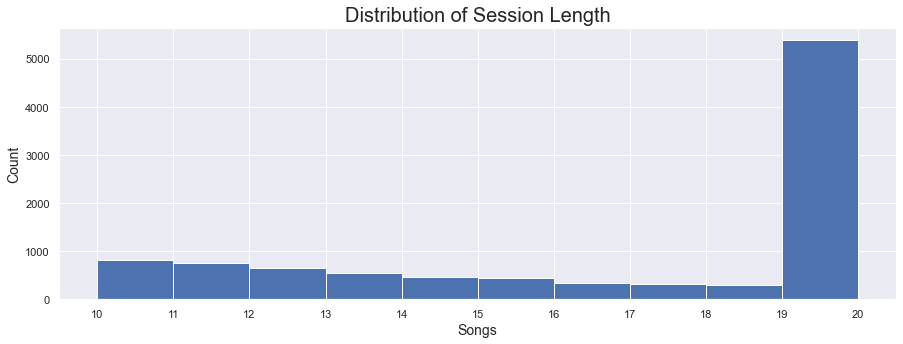

In [3]:
# Plots distribution of Listening Session Length
plt.figure()
session_logs_df.drop_duplicates(subset=['session_id'])['session_length'].plot.hist()
plt.title('Distribution of Session Length')
plt.xlabel('Songs')
plt.ylabel('Count')
plt.xticks(range(10,21,1))
plt.show()

The majority of listening sessions in this dataset were 20 songs long. Beyond that, there appears to be a somewhat even spread of session lengths between 10 and 19 songs. 

---

How many listening sessions were completed by premium Spotify users?

In [4]:
# Gets the distribution of Premium-user listening sessions in the dataset
pd.DataFrame(session_logs_df.drop_duplicates(subset=['session_id'])['premium'].value_counts())

,premium
True,8028
False,1972


Out of a total of 10,000 unique listening sessions in the dataset, just over 8000 of them were completed by a premium user.

---

How are the songs in the session logs distributed in terms of `'context_type'`?

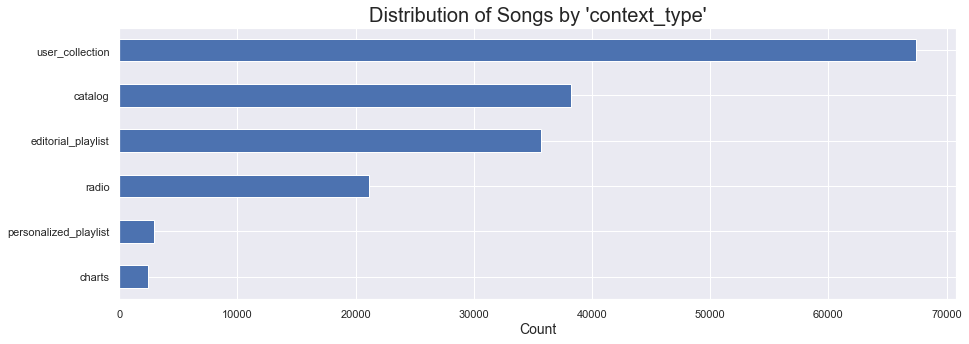

In [5]:
# Plots the distribution of songs by 'context_type'
plt.figure()
session_logs_df['context_type'].value_counts().sort_values().plot.barh()
plt.title("Distribution of Songs by 'context_type'")
plt.xlabel('Count')
plt.show()

Based on the figure above, most of the songs found in the session logs belong to a user collection of songs. Followed by the Spotify catalog and editorial playlists. This is important to consider in case there is a difference between skip rates between `'context_type'` which I will explore during multivariate analysis.

---

What part of the day were users listening to music on Spotify?

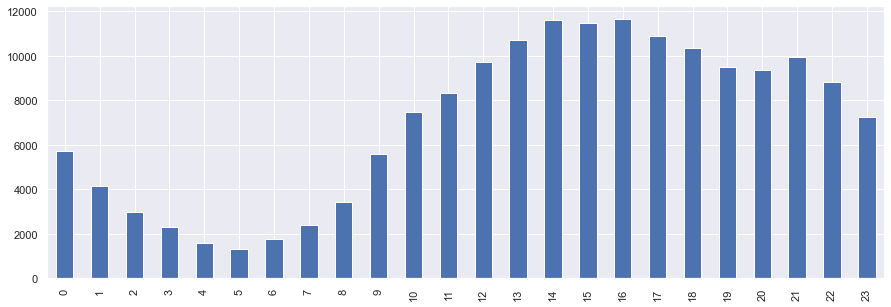

In [6]:
# Plots distribution of songs played by 'hour_of_day'
plt.figure()
session_logs_df['hour_of_day'].value_counts().sort_index().plot.bar()
plt.show()

Listening activity appears to peak in the afternoon, then generally declines towards the 5 AM where listening activity is the lowest. Which would make sense as you'd expected users to be sleeping around that time. Then listening activity appears to increase. Coinciding with when users might have started to wake up and start their day.

---

How is pause behaviour distributed across songs?

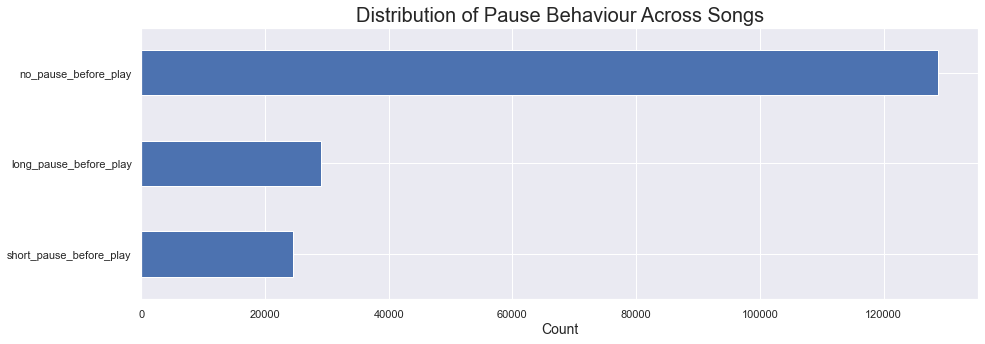

In [7]:
plt.figure()
session_logs_df[['no_pause_before_play', 
                 'short_pause_before_play',
                 'long_pause_before_play']].sum().sort_values().plot.barh()
plt.title('Distribution of Pause Behaviour Across Songs')
plt.xlabel('Count')
plt.show()

Based on the figure above, it would appear that the majority of songs are played with a pause before. This would be expected as Spotify is a music streaming platform and would likely encourage songs to play continuously if possible.

---

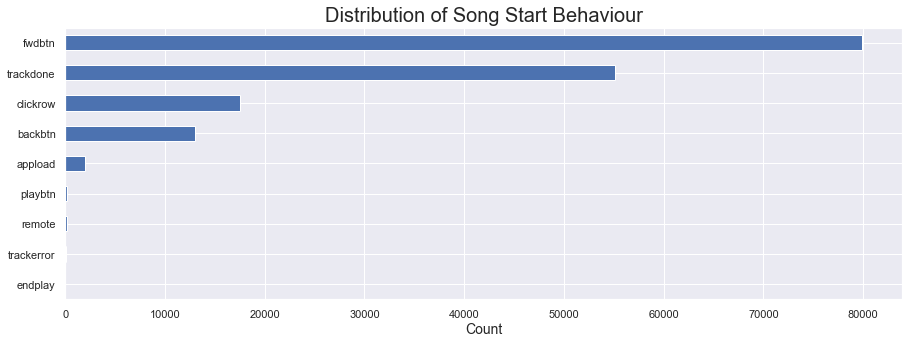

In [8]:
plt.figure()
session_logs_df['hist_user_behavior_reason_start'].value_counts().sort_values().plot.barh()
plt.title('Distribution of Song Start Behaviour')
plt.xlabel('Count')
plt.show()

This is an interesting figure. You can see that songs were started using the forward button more often then there were by having the previous track finish on its own. Which seems to suggest that users might have arrived at the current song with hopes that this is a better song than the previous one in which they had skipped.

---

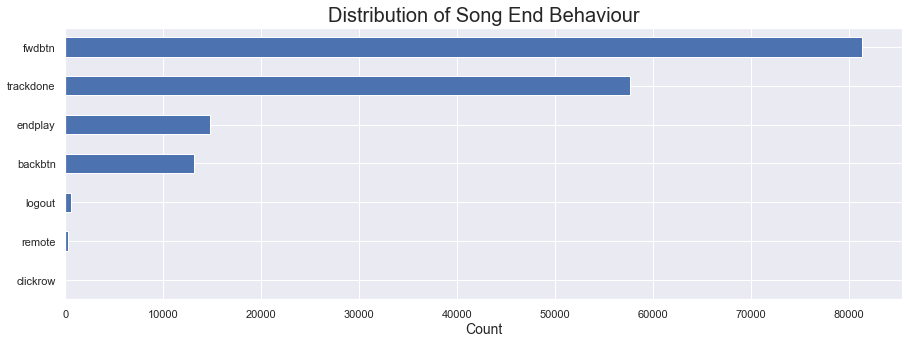

In [9]:
plt.figure()
session_logs_df['hist_user_behavior_reason_end'].value_counts().sort_values().plot.barh()
plt.title('Distribution of Song End Behaviour')
plt.xlabel('Count')
plt.show()

This figure shows the other half of the story in terms of listening experience. If a song starts, it must also end. In this we can see that more often, songs ended by the user pressing the forward button, rather than the song playing out until the end. **It appears that there is a trend starting to emerge in the data. Users seem to be skipping songs more often than they are letting them play until the end.**

---

Finally we'll take a look at skip behaviour in the dataset.

In [10]:
# Gets the mean for each type of skip behaviour
pd.DataFrame(session_logs_df[['skip_1', 'skip_2', 'skip_3', 'not_skipped']].mean(), columns=['mean'])

,mean
skip_1,0.421503
skip_2,0.517179
skip_3,0.648380
not_skipped,0.332881


I haven't brought this up yet. Partly because I hadn't reach this part of the project. But I have yet to converge on a possible target variable for the machine learning problem. This dataset stratifies user skip behaviour by the time it takes for them to skip. In other words, how much of the song had the user played before deciding to skip? A quick review of the differences between the skip behaviours can be referenced using the snippet of the data dictionary from the previous notebook.

|Field|Values|
|-----|------|
|skip_1| Boolean indicating if the track was only played very briefly|
|skip_2|Boolean indicating if the track was only played briefly|
|skip_3| Boolean indicating if most of the track was played|
|not_skipped| Boolean indicating that the track was played in its entirety|

Something to consider when looking at completing a classification task is ensure that there is class balance within the target variable. By referencing the mean values for each skip behaviour. We see that the most balanced variable appears to be `'skip_2'`. In other words, this variable is the closest to a 50-50 between it's positive and negative class. I will re-visit the selection of a target variable when I reach the machine learning portion of this project. But for now `'skip_2'` seems the most likely candidate for being chosen as the target variable.

---

### Key insight: `'skip_2'` is a likely candidate for being the target variable for the machine learning model due to have the best class balance compared to other skip behaviour variables
---

## Exploring Track Features

Quick reminder of the datatypes in `'track_features_df'`

In [11]:
# Gets datatypes in 'track_features_df'
track_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_id                50704 non-null  object 
 1   duration                50704 non-null  float64
 2   release_year            50704 non-null  int64  
 3   us_popularity_estimate  50704 non-null  float64
 4   acousticness            50704 non-null  float64
 5   beat_strength           50704 non-null  float64
 6   bounciness              50704 non-null  float64
 7   danceability            50704 non-null  float64
 8   dyn_range_mean          50704 non-null  float64
 9   energy                  50704 non-null  float64
 10  flatness                50704 non-null  float64
 11  instrumentalness        50704 non-null  float64
 12  key                     50704 non-null  int64  
 13  liveness                50704 non-null  float64
 14  loudness                50704 non-null

Let's do a quick scan through of the distributions of the numeric variables in `'track_features_df'`

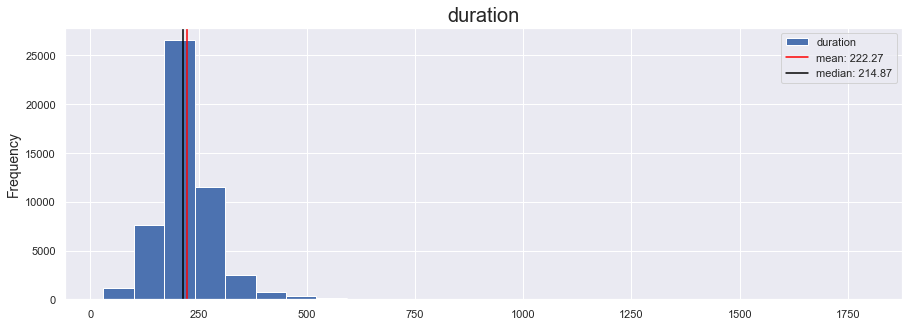

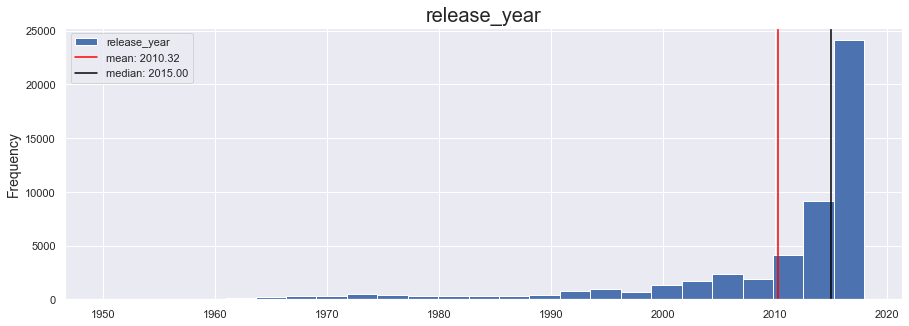

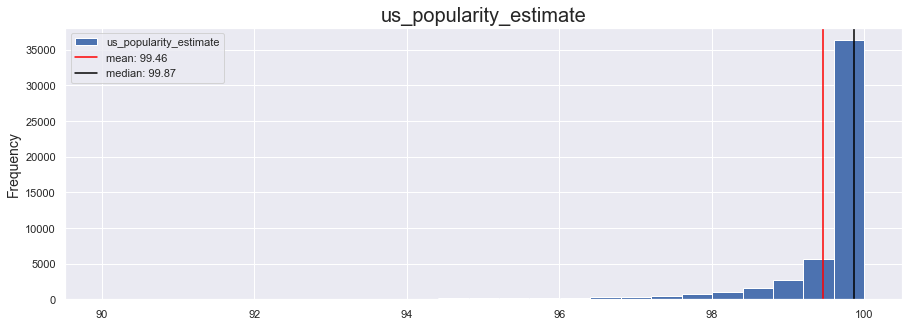

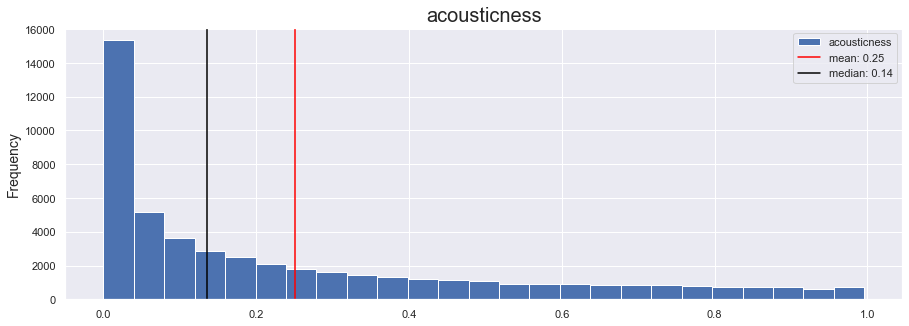

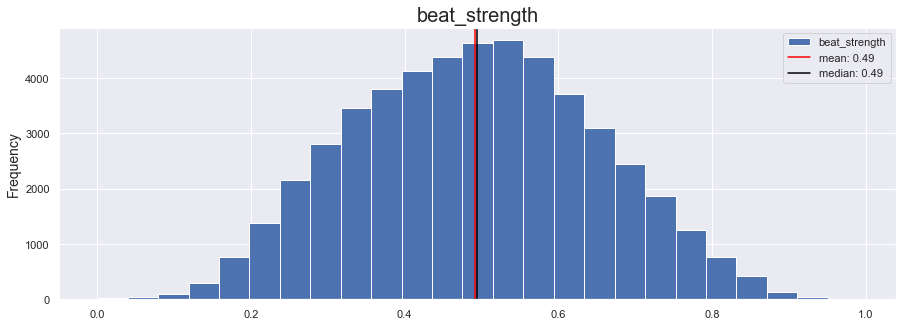

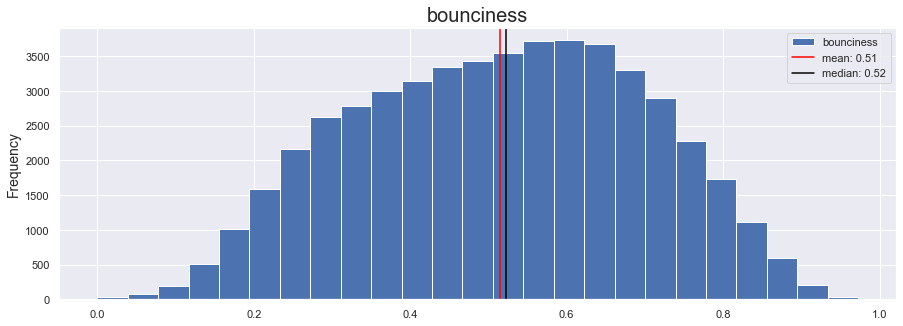

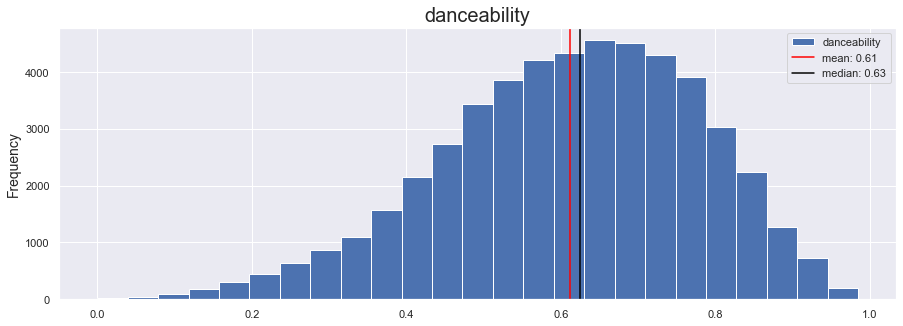

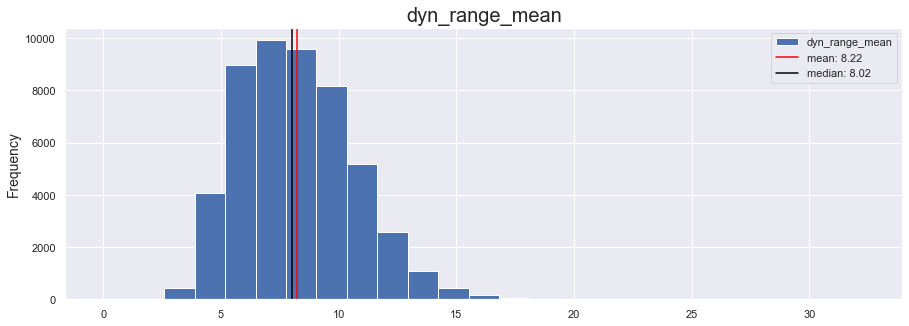

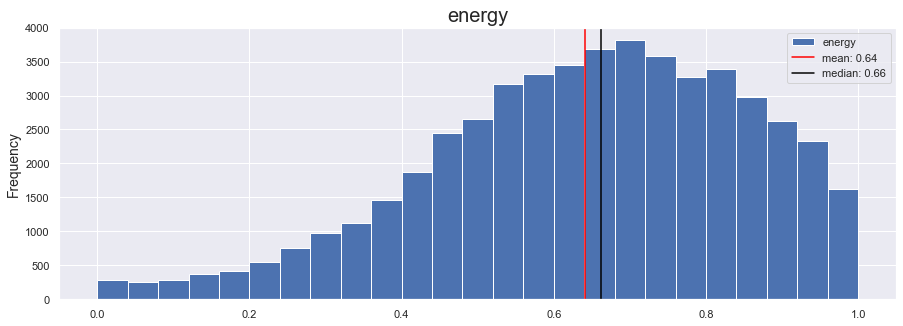

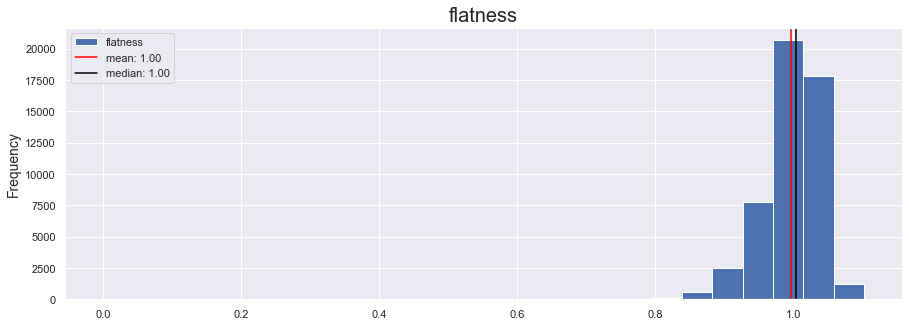

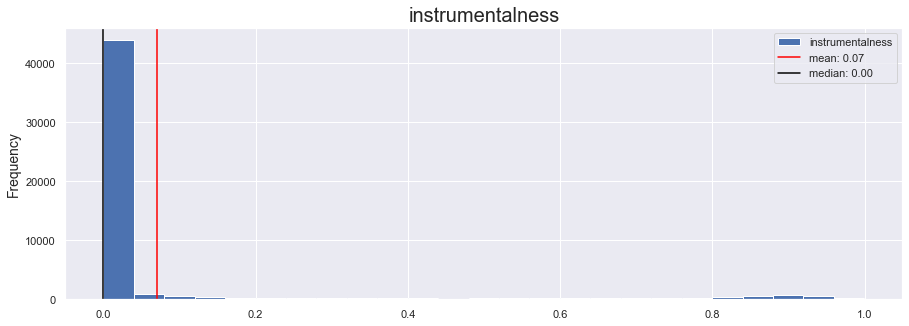

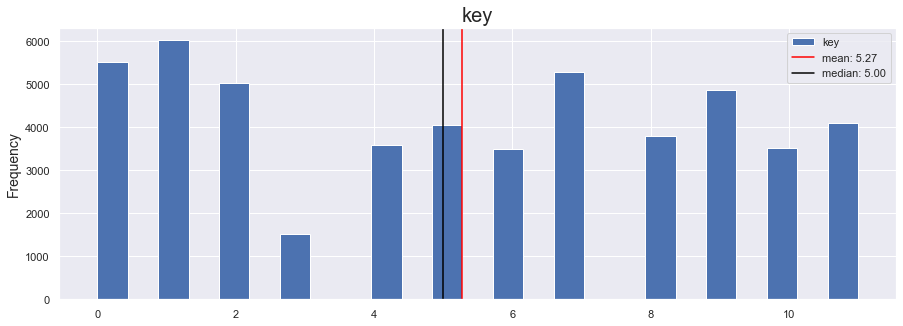

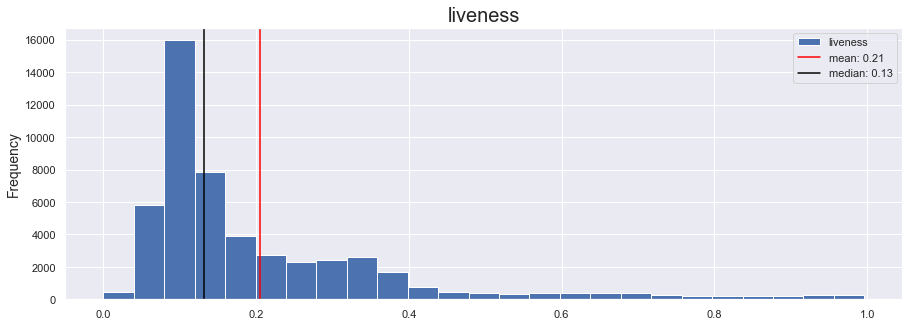

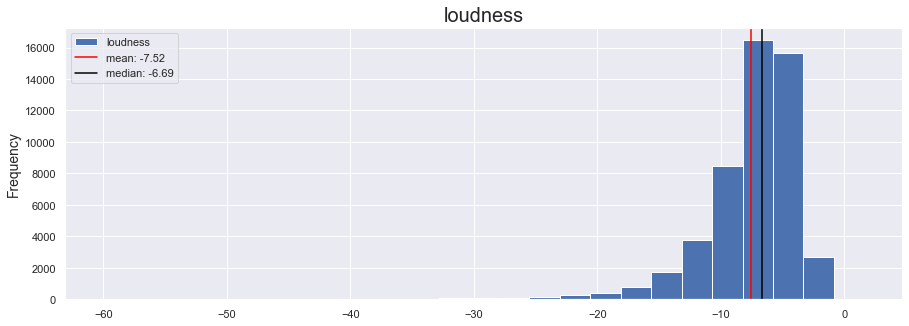

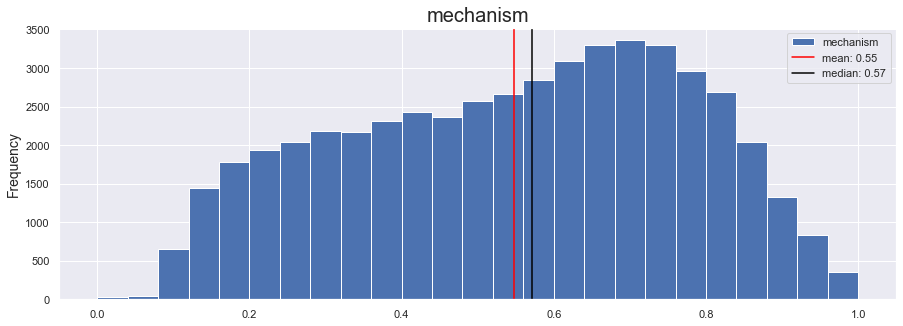

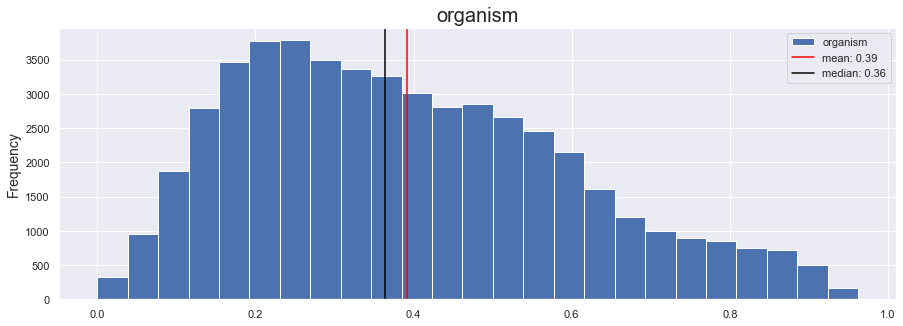

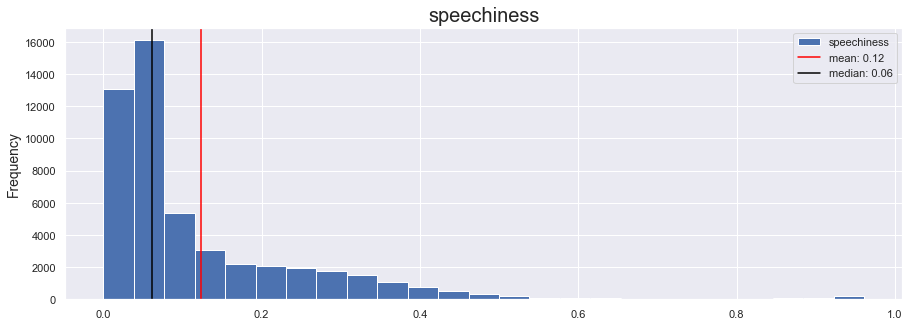

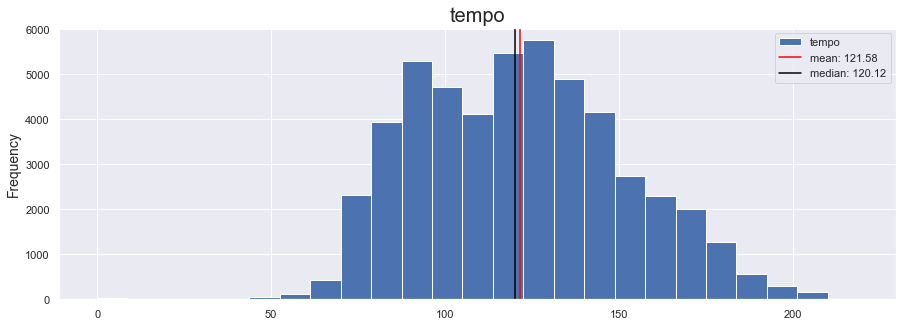

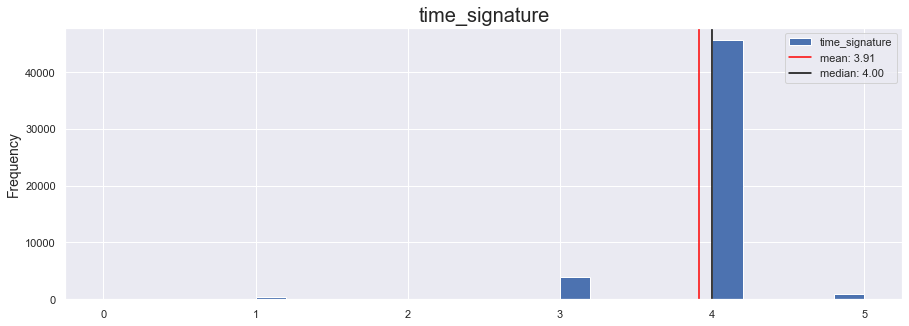

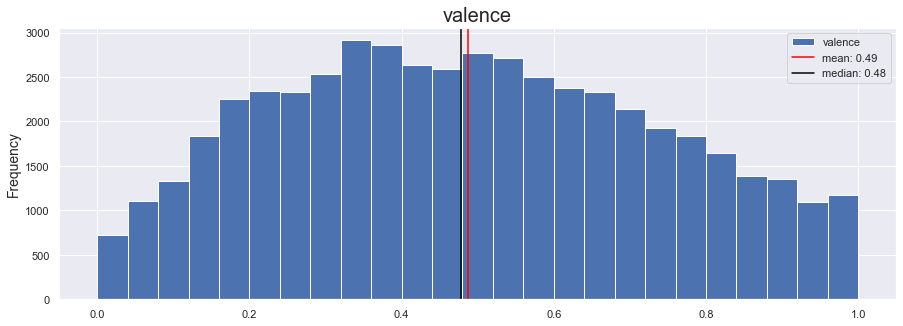

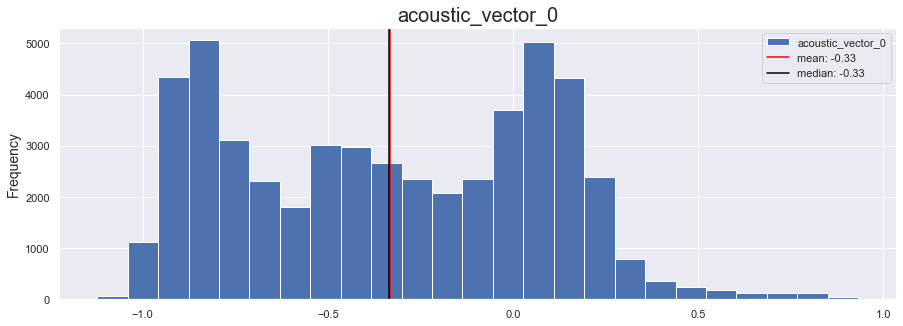

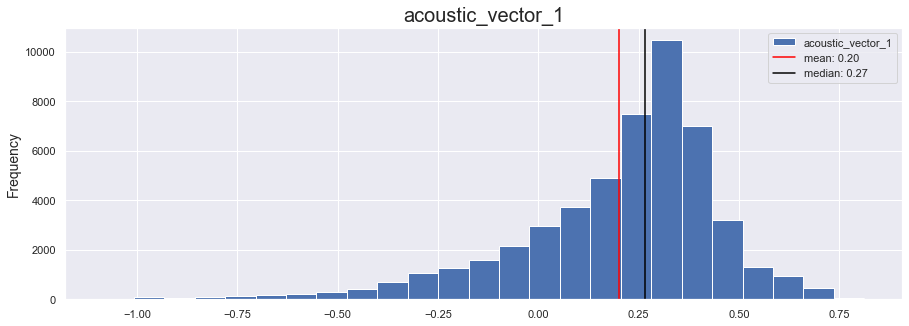

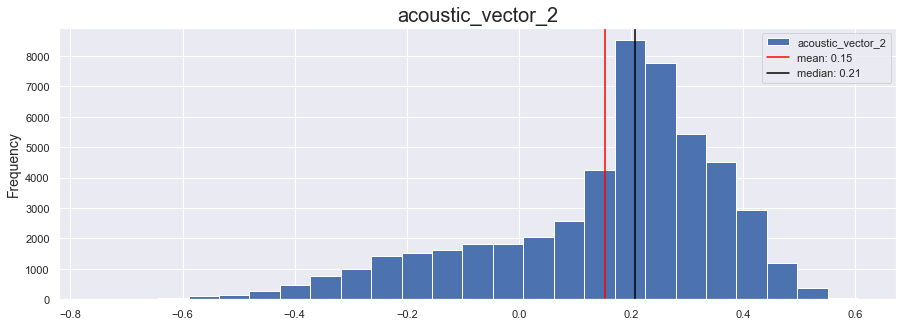

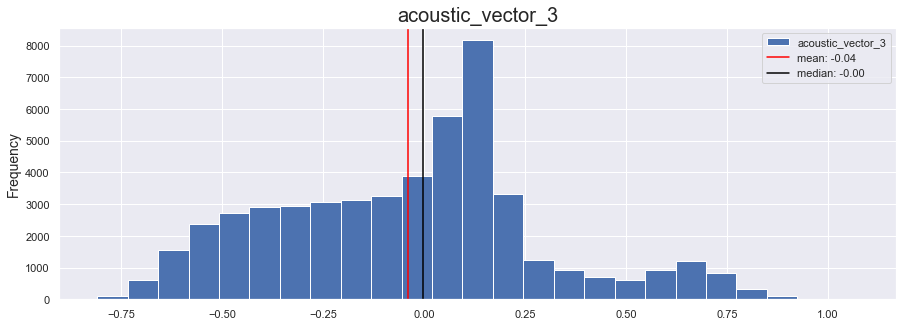

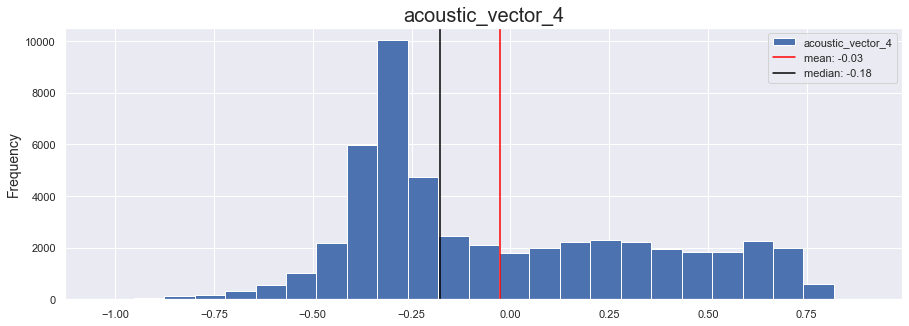

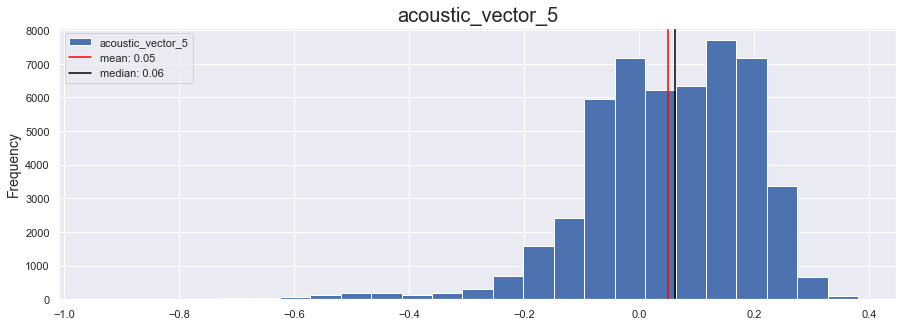

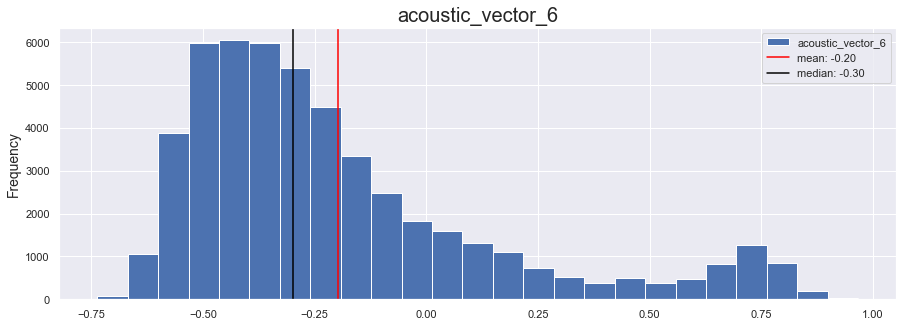

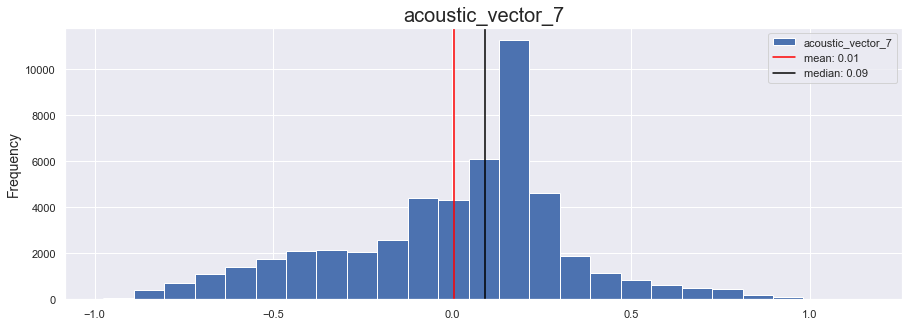

In [12]:
# Loops through columns in 'track_features_df' and plot distribution for each one
for col in track_features_df.columns:
    if track_features_df[col].dtype in ['float64', 'int64']:
        plt.figure()
        track_features_df[col].plot.hist(bins=25)
        plt.axvline(track_features_df[col].mean(), color='red', label=f"mean: {track_features_df[col].mean():.2f}")
        plt.axvline(track_features_df[col].median(), color='black', label=f"median: {track_features_df[col].median():.2f}")
        plt.legend()
        plt.title(col)
        plt.show()

The loop above generated histograms for all the numerical columns in the track features dataframe.

Some things to note are:
- Duration of songs in the data are on average 222 seconds long, but there are some very long songs in the dataset as well
- Most songs in the dataset are more recent songs, which would make sense from a business perspective from Spotify
    - I.E. You'd want to play the most current songs on your platform to drive traffic
- The following plot shows that many songs that were played in the session logs were quite popular, which echos on what would drive the platform
    - I.E. You'd want to play both the most currrent songs, and the most popular songs
- Most songs appear to be lower on the acousticness scale
- `'beat_strength', `'bounciness', `'danceability' all appear to have similiar distributions
    - They all sound like close analogs of each other
    - From layman perspective, it would appear that a song with high `'beat_strength' would make it easier to dance to. Some with `'bounciness'. Perhaps the acoustic characteristics of this make it easier for someone to find the rhythm of the song more readily
    - This is important to consider in case there is some multi-collinearity here

---

# Wrapping up
One of the key take-homes from the univariate analysis is that `'skip_2'` is likely to be a target variable for the machine learning task. In other words, I will be looking to predict whether or not a user plays a song briefly before choosing to skip. `'skip_2'` had the best class balance out of all the variables, and will likely perform better as a target variable as compared to the other variables. The class imbalances in the other variables may present a bias toward the positive or negative class if considered for a machine learning task.

In addition, some of the work done in this notebook will help drive multivariate analysis in the next notebook. I expect to be conducting some statistical analysis, as well as analyzing some of the relationships between the variables. Much of the univariate analysis in this notebook has helped familiarize me with the features. In addition, after exploring the data, I am not as naive to it as I was in the initial stage of this project. 